In [1]:
%pylab inline


from tqdm import trange

Populating the interactive namespace from numpy and matplotlib


In [2]:
def fetch(url):
    import requests,  gzip, os, hashlib, numpy
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=numpy.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1,28,28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1,28,28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

(<matplotlib.image.AxesImage at 0x7fee1a213d00>, 2)

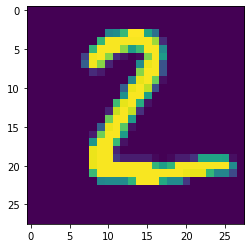

In [3]:
# from pylab import *
imshow(X_test[1]), Y_test[1]

In [4]:
import torch
import torch.nn as nn
class NeuralNet(torch.nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(784,128, bias=False)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(128,10, bias=False)
    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x


loss 0.12 accuracy 0.96: 100%|██████████| 1000/1000 [00:04<00:00, 208.49it/s]


accuracies_mean:  0.9338359375 losses_mean:  0.3783666784893721
accuracies_std:  0.06011719460688716 losses_std:  1.1269545863900072
1000 1000
Percent correct:  0.9522


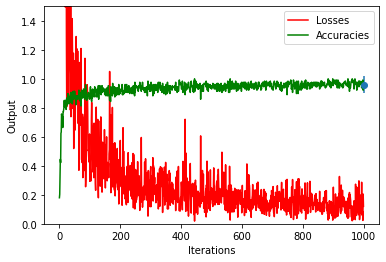

In [5]:
# Training steps

BS = 128
model = NeuralNet()
loss_function= nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())
losses, accuracies = [], []
training_steps = 1000
for i in (t := trange(training_steps)):
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = torch.tensor(X_train[samp].reshape(-1, 28*28)).float()
    Y = torch.tensor(Y_train[samp]).long()
    optim.zero_grad()
    out = model(X)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    loss = loss_function(out, Y)
    loss.backward()
    optim.step()
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    
    
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
    

# Create graph of Accuracy and Loss
accuracies_mean = np.mean(np.array(accuracies))
losses_mean = np.mean(np.array(losses))
print("accuracies_mean: ", accuracies_mean, "losses_mean: ", losses_mean)

accuracies_std = np.std(np.array(accuracies))
losses_std = np.std(np.array(losses))
print("accuracies_std: ", accuracies_std, "losses_std: ", losses_std)
print(len((accuracies)), training_steps)

# setting standard deviation ->

error = [accuracies_std]
fig, ax = plt.subplots()
plt.ylim(0,1.5)
ax.plot(losses, label="Losses", color='r')
ax.plot(accuracies, label="Accuracies", color='g')
ax.errorbar(training_steps, accuracies[training_steps - 1], # -1 for list index inbound
            yerr=error,
       fmt='-o')
ax.set_xlabel("Iterations")
ax.set_ylabel("Output")
ax.legend()
# ax.title("MNIST - Machine Learning numbers")
# find the first 5% of iterations that contribute to the highest learning curve -> find the rate of change for those points
# Find rate of accuracy change for first 5% of points
# Evaluation
results = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
print("Percent correct: ", (Y_test == results).mean())
# return trained model



# Increasing batch size increases precison in accuracies and losses.


In [6]:
# Calculating the derivative 
ri = int(0.1*100)
dx = 1
y = accuracies[0:ri]

dy = np.diff(y)/dx
#
print(dy)

[ 0.0234375  0.1328125  0.109375  -0.0234375  0.203125   0.0078125
  0.125     -0.015625  -0.0390625]


In [7]:
l1 = np.zeros((784, 128), dtype=np.float32)
l2 = np.zeros((128, 10), dtype=np.float32)
l1.dtype, l2.dtype, id(l1), id(l2)


(dtype('float32'), dtype('float32'), 140660617724512, 140660649930384)

In [8]:
l1[:] = model.l1.weight.detach().numpy().transpose()
l2[:] = model.l2.weight.detach().numpy().transpose()

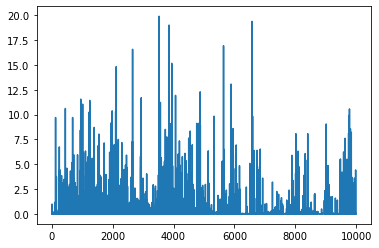

In [9]:
def forward(x):
    x = x.dot(l1)

    x = np.maximum(x, 0)

    x = x.dot(l2)
    return x
Y_test_preds_out = forward(X_test.reshape((-1,28*28)))
Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
(Y_test == Y_test_preds).mean()
    
samp = 1 
ret = -Y_test_preds_out[range(Y_test_preds_out.shape[0]),Y_test] + np.log(np.exp(Y_test_preds_out).sum(axis=1))
plot(ret)

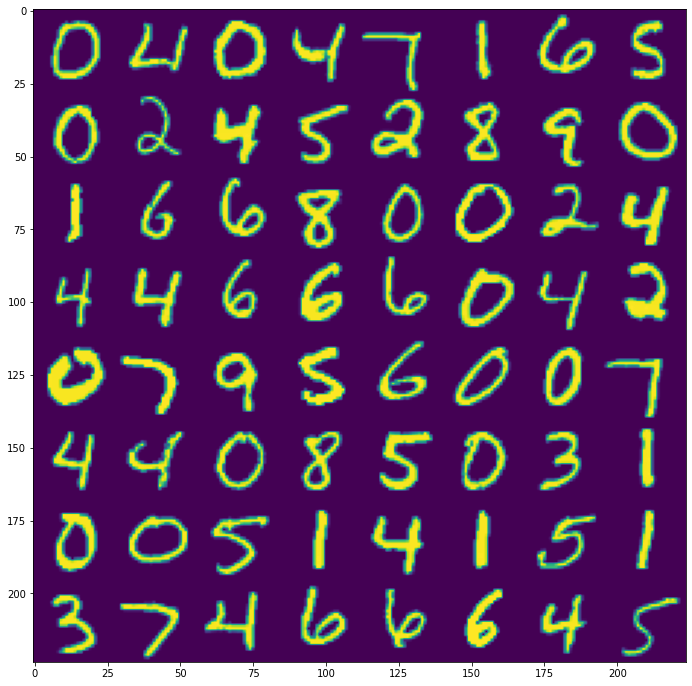

In [11]:
G = 8
grid = sorted(list(zip(ret, range(ret.shape[0]))), reverse=False)[0:G**2]
X_bad = X_test[[x[1] for x in grid]]
figsize(12,12)
imshow(np.concatenate(X_bad.reshape((G, 28*G,28)), axis=1))
